Se tiene un grafo dirigido representado mediante una lista
de adyacencias. Dado un nodo inicial y un nodo final queremos
que programe usando Map-Reduce un algoritmo que indique
cuál es el camino mínimo entre ambos nodos. En clase vimos
como calcular la longitud, ahora queremos saber cuál es el
camino.

[Link](https://piazza.com/class_profile/get_resource/jkr2voxi1yw4wt/jkr2vqsaag24y5)

# Planteo del ejercicio

Voy a presentar primero el caso general de grafos dirigidos con pesos, utilizando el algoritmo de Ford-Bellman distribuido. Luego, voy a mostrar las modificaciones necesarias para tratar con el problema de grafos dirigidos no pesados sencillamente tomando 1 como peso para todas las aristas.

In [1]:
import pygraphviz as pgv
from IPython.display import Image
import numpy as np
from functools import reduce
from pprint import pprint

def draw(G):
    return Image(G.draw(format='png', prog='dot'))

# Camino minimo con Spark para grafos dirigidos pesados

Creo un grafo con listas de adyacencias, con pesos aleatorios entre 1 y 15. Lo grafico con (pygraphviz)[http://pygraphviz.github.io/documentation/pygraphviz-1.4rc1/install.html#quick-install] para poder validar manualmente los resultados obtenidos. 

In [2]:
edges = [('a', [('b', 7)]), 
         ('b', [('c', 8), ('d', 3), ('f', 10)]), 
         ('c', [('e', 6), ('h', 7), ('a', 13)]), 
         ('d', [('g', 13)]), 
         ('e', [('d', 8), ('k', 14)]), 
         ('f', [('b', 2), ('d', 10)]), 
         ('g', [('i', 7)]), 
         ('h', []), 
         ('i', [('d', 13)]), 
         ('j', [('e', 2)]), 
         ('k', [('j', 2)])]

In [3]:
G = pgv.AGraph(directed=True)
for edge in edges:
    G.add_node(edge[0])
    for end in edge[1]:
        G.add_edge(edge[0],end[0],weight=end[1],label=str(end[1]))

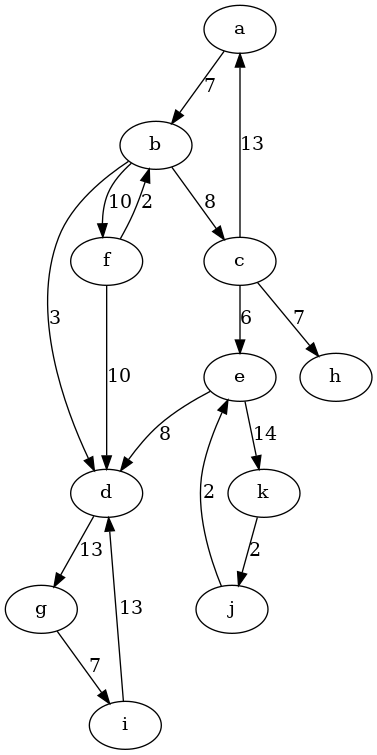

In [4]:
draw(G)

Al usar Map-Reduce no podemos hacer early-stopping si ya llegamos al destino, ya que para ello deberíamos hacer `.collect` del RDD en cada iteración. Esto es una mala práctica, ya que el collect es una operación cara, lenta y que necesita mucho tráfico de datos de los workers al driver. 

Si tenemos un grafo $G = (V,E)$, entonces necesitamos a lo sumo $|V|-1$ iteraciones, ya que ningún camino será mas largo que ese valor. Entonces hay que hacer $|V|-1$ iteraciones de Map-Reduce.

Empezamos con un RDD con un registro por cada vértice, con el siguiente formato:
`(start, weight_total, adj_list, path)`
* **start** un vértice 
* **weight_total** el costo de llegar a ese vértice en esa iteración
* **adj_list** lista de adyacencias para ese vértice

Inicializamos todos los registros con $weight\_total = \infty$ excepto por $start$, con peso $0$.

En la etapa de `map`, para cada registro en el RDD crearemos una lista con:
* el registro original
* una lista de nuevos registros donde `start` es un elemento de `adj_list`, `weight_total` es la suma del peso de ir a ese elemento desde el elemento del registro original y `weight_total` hasta el momento y `adj_list` está vacía
Luego de explicar la etapa de `reduce` quedará claro por qué `adj_list` se crea vacía para esos últimos registros. 

En la etapa de `reduce` lo que hacemos es simplemente seleccionar el menor valor para `weight` de los dos nodos que recibimos. `adj_list` debe ser la lista original para ese nodo. En la etapa de `map` cuando procesamos ese nodo devolvemos la lista original, todos los demás que devolvemos tienen una lista vacía, asi que básicamente sumamos todas las listas vacías y la lista original. `path` será el valor para `path` del nodo con el valor mas pequeño para `weight`.

Encapsulamos toda esa lógica dentro de una función que recibe una lista de listas de adyacencias, el vértice inicial y el final y devuelve un string con el camino y el costo.

Con la lógica explicada previamente en realidad obtenemos el camino minimo del vértice inicial a todos los demas, pero como solo nos interesa el vértice final, con `filter` obtenemos solo ese registro.

In [5]:
def shortest_path(edges,start,end):
    def map_(node):
        lista_nuevos = [node]
        lista_nuevos.extend([(x[0],(node[1][0]+x[1],[],node[1][2]+[x[0]])) for x in node[1][1]])
        return lista_nuevos

    def reduce_(n1,n2):
        weight = n1[0] if n1[0] < n2[0] else n2[0]
        adj = n1[1]+n2[1]
        path = n1[2] if n1[0] < n2[0] else n2[2]
        return (weight,adj,path)
    
    sc.broadcast(end)
    rdd = sc.parallelize([(edgelist[0],(0 if edgelist[0]==start else np.inf,edgelist[1],[edgelist[0]])) for edgelist in edges],8)
    #start, weight_total, adj_list, path
    for _ in range(len(edges)-1):
        rdd = rdd.flatMap(map_).reduceByKey(reduce_)
    rdd = rdd.filter(lambda x: x[0]==end)
    tup = rdd.collect()[0]
    return "No hay camino" if tup[1][2][0] != start else "{} (cost {})".format(" => ".join(tup[1][2]),tup[1][0])

In [6]:
shortest_path(edges,'a','h')

'a => b => c => h (cost 22)'

In [7]:
shortest_path(edges,'d','e')

'No hay camino'

# Camino minimo con Spark para grafos dirigidos no pesados

Voy a usar el mismo grafo, pero esta vez, sin pesos.

In [8]:
adj = [('a',['b']),('b',['c','d','f']),\
      ('c',['e','h','a']),('d',['g']),\
      ('e',['d','k']),('f',['b','d']),('g',['i']),\
      ('h',[]),('i',['d']),('j',['e']),('k',['j'])]

In [9]:
G = pgv.AGraph(directed=True)
for edge in adj:
    G.add_node(edge[0])
    for end in edge[1]:
        G.add_edge(edge[0],end[0])

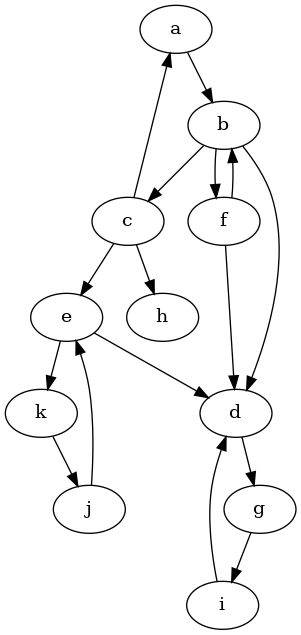

In [10]:
draw(G)

Las única modificacion necesaria para que el algoritmo trabaje con grafos no pesados es "hardcodear" un 1 como peso a sumar en la etapa de `map` (para no agregarlo a cada arista)

In [11]:
def shortest_path(edges,start,end):
    def map_(node):
        lista_nuevos = [node]
        lista_nuevos.extend([(x[0],(node[1][0]+1,[],node[1][2]+[x[0]])) for x in node[1][1]])
        return lista_nuevos

    def reduce_(n1,n2):
        weight = n1[0] if n1[0] < n2[0] else n2[0]
        adj = n1[1]+n2[1]
        path = n1[2] if n1[0] < n2[0] else n2[2]
        return (weight,adj,path)
    
    sc.broadcast(end)
    rdd = sc.parallelize([(edgelist[0],(0 if edgelist[0]==start else np.inf,edgelist[1],[edgelist[0]])) for edgelist in edges],8)
    #start, weight_total, adj_list, path
    for _ in range(len(edges)-1):
        rdd = rdd.flatMap(map_).reduceByKey(reduce_)
    rdd = rdd.filter(lambda x: x[0]==end)
    tup = rdd.collect()[0]
    return "No hay camino" if tup[1][2][0] != start else "{}".format(" => ".join(tup[1][2]))

In [12]:
shortest_path(edges,'g','d')

'g => i => d'

In [13]:
shortest_path(edges,'g','f')

'No hay camino'